
--- Detected Issues ---
Overshoot detected in PID1 (13 instances)
Settling time issues in PID1 (709 instances)
Oscillations detected in PID1 (346 instances)

--- Tuning Suggestions ---

 [{'message': 'Overshoot detected (2.96°C): Reduce Kp of PID1 to prevent excessive cooling.', 'tuning': {'PID1': [1.6, 0.35, 3.45]}}, {'message': 'Long settling time detected: Increase Ki of PID1 for better steady-state tracking.', 'tuning': {'PID1': [2.0, 0.35, 3.0]}}, {'message': 'Oscillations detected: Reduce Kp of PID1 or increase Kd to dampen oscillations.', 'tuning': {'PID1': [2.0, 0.35, 3.0]}}]
setpoint_Of_PID_1(main)
::::::


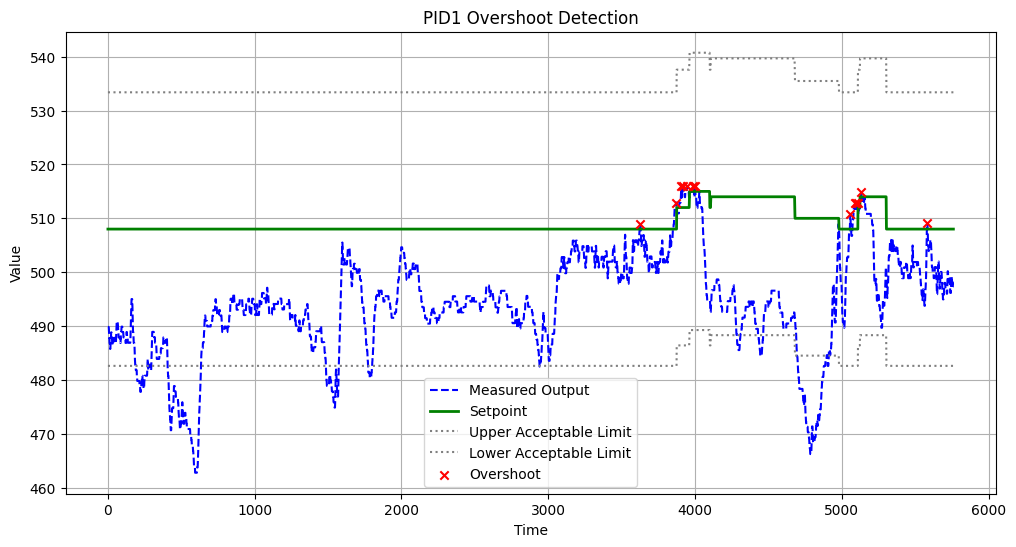

setpoint_of PID_2


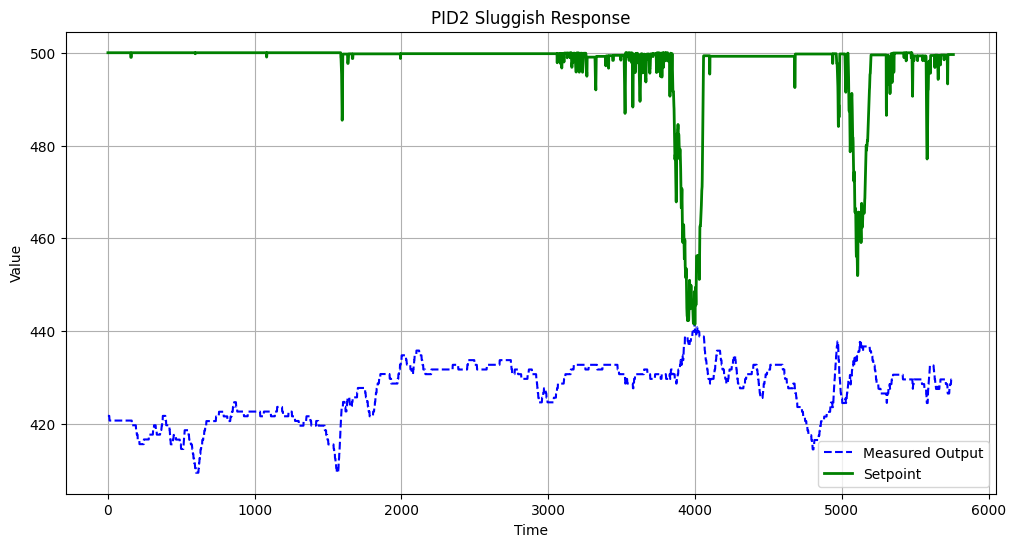

setpoint_Of_PID_1(main)
::::::


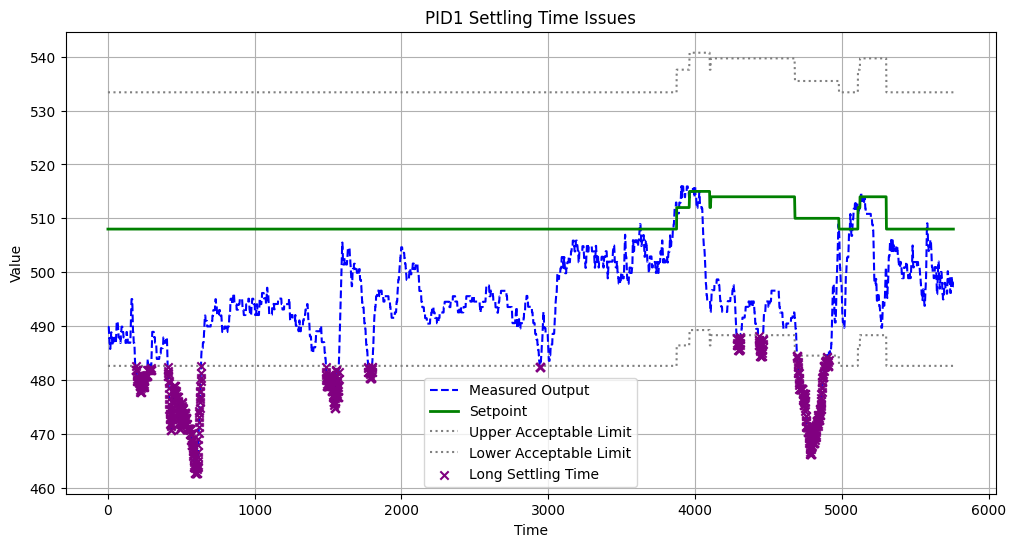

setpoint_Of_PID_1(main)
::::::


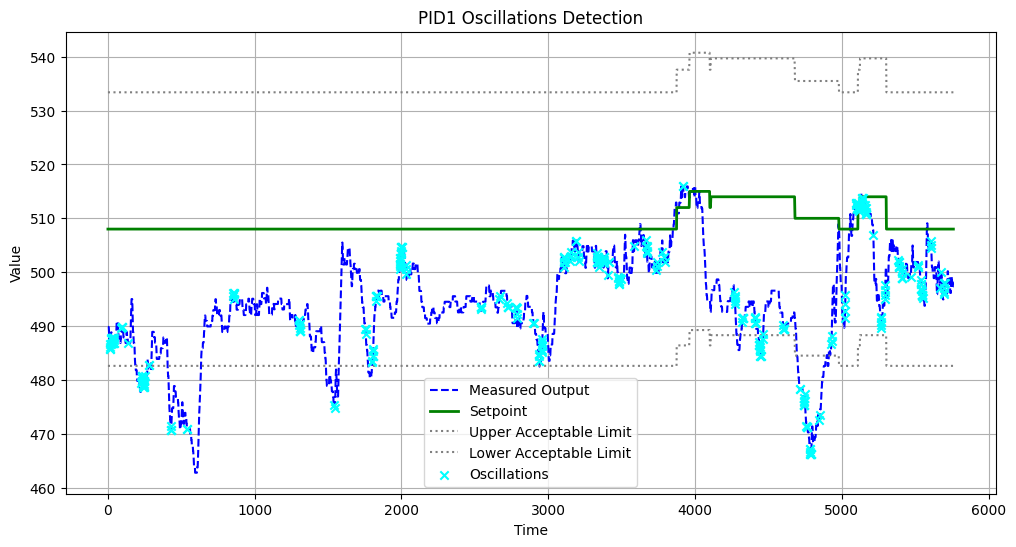

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import minimize
pid_values = {
    "PID1": [2.5, 3.5, 0.30],  # Outer Loop
    "PID2": [2.0, 3.0, 0.35]   # Inner Loop
}

# Load Data
df = pd.read_excel("pidreheater.xlsx")

# Define key columns
pid1_setpoint = "setpoint_Of_PID_1(main)"
pid1_meas = "measureValue_of_outlettemp"
pid2_setpoint = "setpoint_of PID_2"
pid2_meas = "measureValue_of_pid_2"
control_valve = "controlValveopeningpercent"

# Dynamically Compute Control Valve Thresholds
cv_low = df[control_valve].mean() - df[control_valve].std()  # Lower bound
cv_high = df[control_valve].mean() + df[control_valve].std()  # Upper bound

# Function to detect overshoot (Peak Deviation & Rate of Change)
def detect_overshoot(df, pid_setpoint, pid_meas, control_valve):
    peaks, _ = find_peaks(df[pid_meas])
    overshoot_df = df.iloc[peaks].copy()
    overshoot_df["overshoot_amount"] = overshoot_df[pid_meas] - overshoot_df[pid_setpoint]
    overshoot_df = overshoot_df[overshoot_df["overshoot_amount"] > 0]  # True overshoot only
    overshoot_df["control_valve_high"] = overshoot_df[control_valve] > cv_high
    overshoot_df["control_valve_low"] = overshoot_df[control_valve] < cv_low
    return overshoot_df

def detect_undershoot(df, pid_setpoint, pid_meas, control_valve):
    valleys, _ = find_peaks(-df[pid_meas])  # Find local minima (valleys)
    undershoot_df = df.iloc[valleys].copy()
    undershoot_df["undershoot_amount"] = undershoot_df[pid_setpoint] - undershoot_df[pid_meas]
    undershoot_df = undershoot_df[undershoot_df["undershoot_amount"] > 0]  # True undershoot only
    undershoot_df["control_valve_high"] = undershoot_df[control_valve] > cv_high
    undershoot_df["control_valve_low"] = undershoot_df[control_valve] < cv_low
    return undershoot_df



# Function to detect sluggish response (Low Kp or Ki in PID2)
def detect_sluggish_response(df, pid_setpoint, pid_meas, control_valve):
    return df[(df[pid_meas] < df[pid_setpoint]) & (df[control_valve] < cv_low)]

# Function to detect long settling time (Adaptive Threshold)
def detect_settling_time(df, pid_setpoint, pid_meas, tolerance=0.05):  # 5% of setpoint
    error_margin = df[pid_setpoint] * tolerance
    return df[abs(df[pid_meas] - df[pid_setpoint]) > error_margin]

# Function to detect oscillations using Zero-Crossing Rate
def detect_oscillations(df, pid_meas, window=10):
    diff = np.sign(df[pid_meas].diff())
    zero_crossings = (diff != diff.shift(1)).astype(int).rolling(window=window).sum()
    threshold = zero_crossings.quantile(0.90)  # High-frequency changes
    return df[zero_crossings > threshold]

# Run Diagnostics
overshoot_pid1 = detect_overshoot(df, pid1_setpoint, pid1_meas, control_valve)
undershoot_pid1= detect_undershoot(df, pid1_setpoint, pid1_meas,control_valve) 
sluggish_pid2 = detect_sluggish_response(df, pid2_setpoint, pid2_meas, control_valve)
settling_time_pid1 = detect_settling_time(df, pid1_setpoint, pid1_meas)
oscillations_pid1 = detect_oscillations(df, pid1_meas)

def suggest_pid_tuning(issue,pid):
    """Suggest adjustments to Kp, Ki, and Kd based on detected issues."""
    tuning_recommendations = {}

    kp,kd,ki= [2.5, 3.5, 0.30] if issue == "PID1" else [2.0, 3.0, 0.35]


    if issue == "High Oscillations":
        kp -= 0.2 * kp  # Reduce Kp
        kd += 0.15 * kd  # Increase Kd
    elif issue == "High Settling Time":
        kp += 0.15 * kp  # Increase Kp
        ki += 0.10 * ki  # Increase Ki
    elif issue == "Steady-State Error":
        kp += 0.20 * kp  # Increase Kp
        ki += 0.15 * ki  # Increase Ki
    elif issue == "Valve Fully Open But Outlet Temp Low":
        kp += 0.20 * kp
        ki += 0.10 * ki
    elif issue == "Overshoot and control_valve_high":
        kp -= 0.2 * kp  # Reduce Kp to prevent excessive response
        kd += 0.15 * kd  # Increase Kd to dampen overshoot
    elif issue == "Undershoot and control_valve_high":
        kp += 0.2 * kp  # Increase Kp to improve response
        ki += 0.15 * ki  # Increase Ki for better accuracy
    elif issue == "Overshoot and control_valve_low":
        kp += 0.2 * kp  # Increase Kp to improve response
        ki += 0.15 * ki  # Increase Ki for better accuracy
    elif issue == "Undershoot and control_valve_low":
        kp -= 0.2 * kp  # Reduce Kp to prevent excessive response 

    tuning_recommendations[pid] = [kp, ki, kd]

    return tuning_recommendations


# def suggest_tuning(overshoot, undershoot, sluggish, settling, oscillations, df):
#     suggestions = []
#     issues = {}
    
#     if not overshoot.empty:
#         avg_overshoot = overshoot["overshoot_amount"].mean()
#         if overshoot["control_valve_low"].any():
#             issue="Overshoot and control_valve_low"
#             suggestions.append(f"Overshoot detected ({avg_overshoot:.2f}°C): Increase Kp of PID2 to improve spray activation.",suggest_pid_tuning(issue,"PID2"))
#         elif overshoot["control_valve_high"].any():
#             issue="Overshoot and control_valve_high"
#             suggestions.append(f"Overshoot detected ({avg_overshoot:.2f}°C): Reduce Kp of PID1 to prevent excessive cooling.",suggest_pid_tuning(issue,"PID1"))

#     if not undershoot.empty:-
#         avg_undershoot = undershoot["undershoot_amount"].mean()
#         if undershoot["control_valve_high"].any():
#             issue="Undershoot and control_valve_high"
#             suggestions.append(f"Undershoot detected ({avg_undershoot:.2f}°C): Increase Kp of PID1 to improve heating response.",suggest_pid_tuning(issue,"PID1"))
#         elif undershoot["control_valve_low"].any():
#             issue="Undershoot and control_valve_low"
#             suggestions.append(f"Undershoot detected ({avg_undershoot:.2f}°C): Reduce Kp of PID2 to avoid delayed correction.",suggest_pid_tuning(issue,"PID2"))

#     if not sluggish.empty:
#         suggestions.append("Sluggish response detected: Increase Kp or Ki of PID2 to speed up correction.")
    
#     if not settling.empty:
#         suggestions.append("Long settling time detected: Increase Ki of PID1 for better steady-state tracking.")
    
#     if not oscillations.empty:
#         suggestions.append("Oscillations detected: Reduce Kp of PID1 or increase Kd to dampen oscillations.")

#     return suggestions

def suggest_tuning(overshoot, undershoot, sluggish, settling, oscillations, df):
    suggestions = []

    if not overshoot.empty:
        avg_overshoot = overshoot["overshoot_amount"].mean()
        if overshoot["control_valve_low"].any():
            issue = "Overshoot and control_valve_low"
            suggestions.append({
                "message": f"Overshoot detected ({avg_overshoot:.2f}°C): Increase Kp of PID2 to improve spray activation.",
                "tuning": suggest_pid_tuning(issue, "PID2")
            })
        elif overshoot["control_valve_high"].any():
            issue = "Overshoot and control_valve_high"
            suggestions.append({
                "message": f"Overshoot detected ({avg_overshoot:.2f}°C): Reduce Kp of PID1 to prevent excessive cooling.",
                "tuning": suggest_pid_tuning(issue, "PID1")
            })

    if not undershoot.empty:
        avg_undershoot = undershoot["undershoot_amount"].mean()
        if undershoot["control_valve_high"].any():
            issue = "Undershoot and control_valve_high"
            suggestions.append({
                "message": f"Undershoot detected ({avg_undershoot:.2f}°C): Increase Kp of PID1 to improve heating response.",
                "tuning": suggest_pid_tuning(issue, "PID1")
            })
        elif undershoot["control_valve_low"].any():
            issue = "Undershoot and control_valve_low"
            suggestions.append({
                "message": f"Undershoot detected ({avg_undershoot:.2f}°C): Reduce Kp of PID2 to avoid delayed correction.",
                "tuning": suggest_pid_tuning(issue, "PID2")
            })

    if not sluggish.empty:
        suggestions.append({
            "message": "Sluggish response detected: Increase Kp or Ki of PID2 to speed up correction.",
            "tuning": suggest_pid_tuning("Sluggish", "PID2")
        })
    
    if not settling.empty:
        suggestions.append({
            "message": "Long settling time detected: Increase Ki of PID1 for better steady-state tracking.",
            "tuning": suggest_pid_tuning("Settling", "PID1")
        })
    
    if not oscillations.empty:
        suggestions.append({
            "message": "Oscillations detected: Reduce Kp of PID1 or increase Kd to dampen oscillations.",
            "tuning": suggest_pid_tuning("Oscillations", "PID1")
        })

    return suggestions


tuning_suggestions = suggest_tuning(overshoot_pid1,undershoot_pid1, sluggish_pid2, settling_time_pid1, oscillations_pid1, df)

# Display Results
print("\n--- Detected Issues ---")
if not overshoot_pid1.empty:
    print(f"Overshoot detected in PID1 ({len(overshoot_pid1)} instances)")
if not sluggish_pid2.empty:
    print(f"Sluggish response detected in PID2 ({len(sluggish_pid2)} instances)")
if not settling_time_pid1.empty:
    print(f"Settling time issues in PID1 ({len(settling_time_pid1)} instances)")
if not oscillations_pid1.empty:
    print(f"Oscillations detected in PID1 ({len(oscillations_pid1)} instances)")

print("\n--- Tuning Suggestions ---")
print("\n",tuning_suggestions)

# Function to plot issues
def plot_issues(df, issue_df, pid_meas, pid_setpoint, title, color, label, tolerance=0.05):
    plt.figure(figsize=(12, 6))
    
    # Plot measured output
    plt.plot(df.index, df[pid_meas], label="Measured Output", linestyle="--", color="blue")
    
    # Plot setpoint
    plt.plot(df.index, df[pid_setpoint], label="Setpoint", linestyle="-", color="green", linewidth=2)
    print(pid_setpoint)
    
    # Plot acceptable range (for PID1 cases)
    if "PID_1" in pid_setpoint:
        print("::::::")
        upper_limit = df[pid_setpoint] * (1 + tolerance)
        lower_limit = df[pid_setpoint] * (1 - tolerance)
        
        plt.plot(df.index, upper_limit, linestyle="dotted", color="gray", label="Upper Acceptable Limit", zorder=3)
        plt.plot(df.index, lower_limit, linestyle="dotted", color="gray", label="Lower Acceptable Limit", zorder=3)

    # Highlight issue points
    if not issue_df.empty:
        plt.scatter(issue_df.index, issue_df[pid_meas], color=color, label=label, marker='x', zorder=4)

    # Labels and legend
    plt.legend()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

# Overshoot Plot
# Overshoot Plot
plot_issues(df, overshoot_pid1, pid1_meas, pid1_setpoint, "PID1 Overshoot Detection", "red", "Overshoot")

# Sluggish Response Plot
plot_issues(df, sluggish_pid2, pid2_meas, pid2_setpoint, "PID2 Sluggish Response", "orange", "Sluggish Response")

# Settling Time Plot
plot_issues(df, settling_time_pid1, pid1_meas, pid1_setpoint, "PID1 Settling Time Issues", "purple", "Long Settling Time")

# Oscillations Plot
plot_issues(df, oscillations_pid1, pid1_meas, pid1_setpoint, "PID1 Oscillations Detection", "cyan", "Oscillations")



#simulator of pid .

In [14]:
tuning_suggestions

[{'message': 'Overshoot detected (2.96°C): Reduce Kp of PID1 to prevent excessive cooling.',
  'tuning': {'PID1': [1.6, 0.35, 3.45]}},
 {'message': 'Long settling time detected: Increase Ki of PID1 for better steady-state tracking.',
  'tuning': {'PID1': [2.0, 0.35, 3.0]}},
 {'message': 'Oscillations detected: Reduce Kp of PID1 or increase Kd to dampen oscillations.',
  'tuning': {'PID1': [2.0, 0.35, 3.0]}}]

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

app = Flask(__name__)

@app.route("/analyze", methods=["POST"])
def analyze_pid():
    # Get uploaded file
    if 'file' not in request.files:
        return jsonify({"error": "No file provided"}), 400
    
    file = request.files['file']
    df = pd.read_excel(file)  #replace with database data

    # Column Names
    pid1_setpoint = "setpoint_Of_PID_1(main)"
    pid1_meas = "measureValue_of_outlettemp"
    pid2_setpoint = "setpoint_of PID_2"
    pid2_meas = "measureValue_of_pid_2"
    control_valve = "controlValveopeningpercent"

    # Thresholds
    cv_low = df[control_valve].mean() - df[control_valve].std()
    cv_high = df[control_valve].mean() + df[control_valve].std()

    # Detect functions
    def detect_overshoot(df):
        peaks, _ = find_peaks(df[pid1_meas])
        overshoot_df = df.iloc[peaks].copy()
        overshoot_df["overshoot_amount"] = overshoot_df[pid1_meas] - overshoot_df[pid1_setpoint]
        overshoot_df = overshoot_df[overshoot_df["overshoot_amount"] > 0]
        overshoot_df["control_valve_high"] = overshoot_df[control_valve] > cv_high
        overshoot_df["control_valve_low"] = overshoot_df[control_valve] < cv_low
        return overshoot_df

    def detect_undershoot(df):
        valleys, _ = find_peaks(-df[pid1_meas])
        undershoot_df = df.iloc[valleys].copy()
        undershoot_df["undershoot_amount"] = undershoot_df[pid1_setpoint] - undershoot_df[pid1_meas]
        undershoot_df = undershoot_df[undershoot_df["undershoot_amount"] > 0]
        undershoot_df["control_valve_high"] = undershoot_df[control_valve] > cv_high
        undershoot_df["control_valve_low"] = undershoot_df[control_valve] < cv_low
        return undershoot_df

    def suggest_pid_tuning(issue, pid):
        kp, kd, ki = [2.5, 3.5, 0.30] if pid == "PID1" else [2.0, 3.0, 0.35]
        if issue == "Overshoot and control_valve_high":
            kp -= 0.2 * kp
            kd += 0.15 * kd
        elif issue == "Overshoot and control_valve_low":
            kp += 0.2 * kp
            ki += 0.15 * ki
        elif issue == "Undershoot and control_valve_high":
            kp += 0.2 * kp
            ki += 0.15 * ki
        elif issue == "Undershoot and control_valve_low":
            kp -= 0.2 * kp
        return {"pid": pid, "kp": kp, "ki": ki, "kd": kd}

    # Run diagnostics
    overshoot = detect_overshoot(df)
    undershoot = detect_undershoot(df)

    suggestions = []
    if not overshoot.empty:
        avg_overshoot = overshoot["overshoot_amount"].mean()
        if overshoot["control_valve_low"].any():
            suggestions.append({
                "message": f"Overshoot ({avg_overshoot:.2f}°C): Increase Kp of PID2.",
                "tuning": suggest_pid_tuning("Overshoot and control_valve_low", "PID2")
            })
        elif overshoot["control_valve_high"].any():
            suggestions.append({
                "message": f"Overshoot ({avg_overshoot:.2f}°C): Reduce Kp of PID1.",
                "tuning": suggest_pid_tuning("Overshoot and control_valve_high", "PID1")
            })
    if not undershoot.empty:
        avg_undershoot = undershoot["undershoot_amount"].mean()
        if undershoot["control_valve_low"].any():
            suggestions.append({
                "message": f"Undershoot ({avg_undershoot:.2f}°C): Reduce Kp of PID2.",
                "tuning": suggest_pid_tuning("Undershoot and control_valve_low", "PID2")
            })
        elif undershoot["control_valve_high"].any():
            suggestions.append({
                "message": f"Undershoot ({avg_undershoot:.2f}°C): Increase Kp of PID1.",
                "tuning": suggest_pid_tuning("Undershoot and control_valve_high", "PID1")
            })

    # Prepare data for plotting
    plot_data = {
        "time": df.index.tolist(),  # You may also send actual datetime if available
        "setpoint": df[pid1_setpoint].tolist(),
        "measured": df[pid1_meas].tolist(),
        "control_valve": df[control_valve].tolist()
    }

    return jsonify({
        "suggestions": suggestions,
        "plot_data": plot_data
    })

if __name__ == "__main__":
    app.run(debug=True)


In [ ]:
#JAVA SCRIPT
const formData = new FormData();
formData.append("file", document.querySelector("#fileInput").files[0]);

fetch("/analyze", {
  method: "POST",
  body: formData
})
.then(res => res.json())
.then(data => {
  console.log(data.suggestions);  // Show in UI
  const time = data.plot_data.time;
  const setpoint = data.plot_data.setpoint;
  const measured = data.plot_data.measured;

  // Plot with Chart.js or similar here
});


In [ ]:
from flask import Flask, jsonify, send_from_directory
import pandas as pd

app = Flask(__name__, static_folder='static')

# Dummy function to simulate loading sensor data
def load_sensor_df(sensor_id):
    time_index = pd.date_range(start="2023-01-01", periods=100, freq='T')
    df = pd.DataFrame(index=time_index)
    df["measured"] = 50 + pd.Series(range(100)).apply(lambda x: x % 10)
    df["setpoint"] = 55
    return df

# Dummy function to simulate issue detection
def detect_issues(df):
    overshoot = df[df["measured"] > df["setpoint"] + 2]
    sluggish = df[df["measured"] < df["setpoint"] - 3]
    settling = df.iloc[10:20]
    oscillations = df.iloc[30:35]
    return {
        "overshoot": overshoot,
        "sluggish": sluggish,
        "settling": settling,
        "oscillations": oscillations
    }

@app.route('/api/sensor-data/<sensor_id>')
def get_sensor_data(sensor_id):
    df = load_sensor_df(sensor_id)
    issues = detect_issues(df)
    return jsonify({
        "sensor_id": sensor_id,
        "data": df.reset_index().rename(columns={'index': 'time'}).to_dict(orient="records"),
        "issues": {
            k: v.reset_index().rename(columns={'index': 'time'}).to_dict(orient="records")
            for k, v in issues.items()
        }
    })

# Serve static files
@app.route('/')
def index():
    return send_from_directory('static', 'index.html')

@app.route('/<path:path>')
def serve_static(path):
    return send_from_directory('static', path)

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Sensor Plot Dashboard</title>
  <link rel="stylesheet" href="style.css">
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
</head>
<body>
  <div class="container">
    <h1>Sensor Data Plot</h1>
    <label for="sensorSelect">Select Sensor:</label>
    <select id="sensorSelect">
      <option value="pid1">PID 1</option>
      <option value="pid2">PID 2</option>
    </select>
    <div id="plot"></div>
  </div>
  <script src="main.js"></script>
</body>
</html>


In [ ]:
body {
  font-family: Arial, sans-serif;
  margin: 0;
  padding: 20px;
  background-color: #f7f7f7;
}

.container {
  max-width: 900px;
  margin: auto;
  background: white;
  padding: 20px;
  border-radius: 10px;
  box-shadow: 0 2px 10px rgba(0, 0, 0, 0.1);
}

#plot {
  margin-top: 30px;
}


In [ ]:
document.getElementById('sensorSelect').addEventListener('change', async (e) => {
  const sensorId = e.target.value;
  const response = await fetch(`/api/sensor-data/${sensorId}`);
  const json = await response.json();

  const time = json.data.map(d => d.time);
  const measured = json.data.map(d => d.measured);
  const setpoint = json.data.map(d => d.setpoint);

  const overshoot = json.issues.overshoot.map(p => ({ x: p.time, y: p.measured }));
  const sluggish = json.issues.sluggish.map(p => ({ x: p.time, y: p.measured }));
  const settling = json.issues.settling.map(p => ({ x: p.time, y: p.measured }));
  const oscillations = json.issues.oscillations.map(p => ({ x: p.time, y: p.measured }));

  const traces = [
    { x: time, y: measured, mode: 'lines', name: 'Measured Output', line: { color: 'blue', dash: 'dot' }},
    { x: time, y: setpoint, mode: 'lines', name: 'Setpoint', line: { color: 'green' }},
    { x: overshoot.map(p => p.x), y: overshoot.map(p => p.y), mode: 'markers', name: 'Overshoot', marker: { color: 'red', symbol: 'x', size: 8 }},
    { x: sluggish.map(p => p.x), y: sluggish.map(p => p.y), mode: 'markers', name: 'Sluggish', marker: { color: 'orange', symbol: 'triangle-down', size: 8 }},
    { x: settling.map(p => p.x), y: settling.map(p => p.y), mode: 'markers', name: 'Settling Time', marker: { color: 'purple', symbol: 'square', size: 8 }},
    { x: oscillations.map(p => p.x), y: oscillations.map(p => p.y), mode: 'markers', name: 'Oscillations', marker: { color: 'cyan', symbol: 'diamond', size: 8 }}
  ];

  Plotly.newPlot('plot', traces, {
    title: `Sensor: ${sensorId}`,
    xaxis: { title: 'Time' },
    yaxis: { title: 'Value' },
    margin: { t: 40, r: 10, l: 50, b: 50 }
  });
});

// Trigger on load
document.getElementById('sensorSelect').dispatchEvent(new Event('change'));


In [ ]:
{"setpointPrimary": "KAWAI_U2_1ST_STG_LHS_MN_P_PID_SP",
"measureValuePrimary": "KAWAI_U2_1ST_STG_LHS_MN_P_PID_MEAS",
"outputPrimary"  : "KAWAI_U2_1ST_STG_LHS_MN_P_PID_OP",
"setpointSecondary": "KAWAI_U2_1ST_STG_LHS_MN_S_PID_SP",
"measureValueSecondary": "KAWAI_U2_1ST_STG_LHS_MN_S_PID_MEAS",
"controlvalveSecondary"  : "KAWAI_U2_1ST_STG_LHS_MN_S_PID_OP"}